## 追加事例1 欠陥・疾患判定の自動化（2値分類と再現率）

In [1]:
# 共通事前処理

# データフレーム表示用関数
from IPython.display import display
# ライブラリーのインポート
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# 余分なワーニングを非表示にする
import warnings
warnings.filterwarnings("ignore")

# 表示オプション
# NumPyの浮動小数点の表示精度
np.set_printoptions(suppress=True, precision=4)
# pandasの浮動小数点の表示精度
pd.options.display.float_format = "{:.4f}".format
# データフレームのすべての項目を表示
pd.set_option("display.max_columns", None)
# グラフのスタイルの設定
plt.style.use('seaborn')
# グラフのデフォルトフォント設定
plt.rcParams["font.size"] = 14
# グラフで日本語表示が可能なフォントの設定
plt.rcParams["font.family"] = 'IPAexGothic'
# 乱数の種pytho
RANDOM_SEED = 123

In [2]:
# 混合行列の表示用関数

def make_cm(matrix, columns):
    # matrix numpy配列

    # columns項目リスト
    n = len(columns)

    # 「正解データ」をn回繰り返すリスト生成
    act = ['正解データ'] * n
    pred = ['予測結果'] * n

    # データフレーム生成
    cm = pd.DataFrame(
        matrix, columns=[pred, columns], index=[act, columns]
    )
    return cm

### 1.4 データ読み込みからデータ確認まで

項目メモ

- age: 年齢
- sex: 性別
  - 1: 男性
  - 0: 女性
- cp: 胸痛種別
  - 1: 典型的な狭心症
  - 2: 非定型狭心症
  - 3: 非狭心痛
  - 4: 無症候性
- trestbps: 安静時血圧（入院時のmm Hg単位）
- chol: 血清コレステロール（mg / dl）
- fbs: 空腹時血糖（> 120 (mg / dl））
  - 1: 真
  - 0: 偽
- restecg: 安静時心電図
  - 0: 通常
  - 1: ST-T波異常（T波反転および/またはST上昇または抑圧> 0.05 mV）
  - 2: 左心室肥大の可能性あり
- thalach: 最大心拍数
- exang: 運動誘発性狭心症
  - 1: はい
  - 0: いいえ
- oldpeak: ST低下（運動により誘発される安静時と比較したST低下）
- slope: STセグメント勾配（ピーク運動STセグメント勾配）
  - 1: 上昇
  - 2: フラット
  - 3:下降
- ca: 主要血管数（X線透視撮影で着色された主要な血管数（0〜3））
- thal: タール（タリウム心臓スキャンの結果）
  - 3: 通常
  - 6: 修正された欠陥
  - 7: 回復可能な欠陥

&nbsp;

- num (目的変数)
  - 心臓病診断（血管造影の状態）
    - 0: 所見なし
    - 1: 所見あり

In [3]:
# 心疾患公開データ読み込み

columns = [
    '年齢', '性別', '胸痛種別', '安静時血圧',  '血清コレステロール',
    '空腹時血糖値', '安静時心電図',  '最大心拍数',  '運動誘発性狭心症',
    'ST低下', 'STセグメント勾配', '主要血管数', 'タール', '心臓病診断'
]

# 公開データセットのURL
url_hu = 'https://archive.ics.uci.edu/ml/machine-learning-databases/\
heart-disease/processed.hungarian.data'

# データフレームへの取り込み
# 欠損値は'?'で表現されているので、読み込み時にPythonのNaNに変換する
df_hu = pd.read_csv(
    url_hu, header=None, names=columns, na_values='?'
)

In [4]:
# データ全体の確認

display(df_hu.head())
display(df_hu.tail())

(294, 14)


,年齢,性別,胸痛種別,安静時血圧,血清コレステロール,空腹時血糖値,安静時心電図,最大心拍数,運動誘発性狭心症,ST低下,STセグメント勾配,主要血管数,タール,心臓病診断
0,28,1,2,130.0000,132.0000,0.0000,2.0000,185.0000,0.0000,0.0000,NaN,NaN,NaN,0
1,29,1,2,120.0000,243.0000,0.0000,0.0000,160.0000,0.0000,0.0000,NaN,NaN,NaN,0
2,29,1,2,140.0000,NaN,0.0000,0.0000,170.0000,0.0000,0.0000,NaN,NaN,NaN,0
3,30,0,1,170.0000,237.0000,0.0000,1.0000,170.0000,0.0000,0.0000,NaN,NaN,6.0000,0
4,31,0,2,100.0000,219.0000,0.0000,1.0000,150.0000,0.0000,0.0000,NaN,NaN,NaN,0


,年齢,性別,胸痛種別,安静時血圧,血清コレステロール,空腹時血糖値,安静時心電図,最大心拍数,運動誘発性狭心症,ST低下,STセグメント勾配,主要血管数,タール,心臓病診断
289,52,1,4,160.0000,331.0000,0.0000,0.0000,94.0000,1.0000,2.5000,NaN,NaN,NaN,1
290,54,0,3,130.0000,294.0000,0.0000,1.0000,100.0000,1.0000,0.0000,2.0000,NaN,NaN,1
291,56,1,4,155.0000,342.0000,1.0000,0.0000,150.0000,1.0000,3.0000,2.0000,NaN,NaN,1
292,58,0,2,180.0000,393.0000,0.0000,0.0000,110.0000,1.0000,1.0000,2.0000,NaN,7.0000,1
293,65,1,4,130.0000,275.0000,0.0000,1.0000,115.0000,1.0000,1.0000,2.0000,NaN,NaN,1


In [5]:
# 学習データ件数と項目数確認

print(df_hu.shape)
print()

# 「心臓病診断」の値の分布確認
print(df_hu['心臓病診断'].value_counts())
print()

# 所見あり比率
rate = df_hu['心臓病診断'].value_counts()[1] / len(df_hu)
print(f'有症率: {rate:.4f}')

(294, 14)

0    188
1    106
Name: 心臓病診断, dtype: int64

有症率: 0.3605


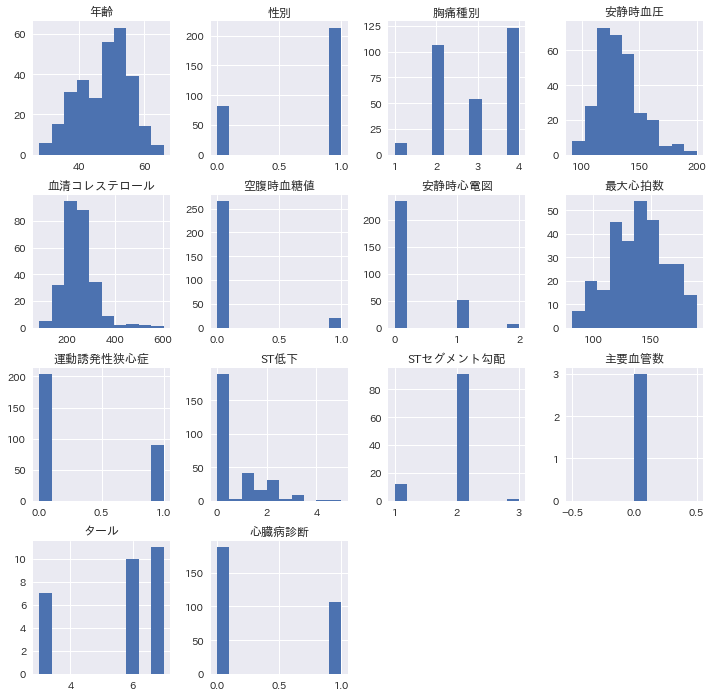

In [7]:
# ヒストグラム表示

from pylab import rcParams

# グラフのサイズ調整のためのおまじない
rcParams['figure.figsize'] = (12, 12)

# データフレームの数値項目でヒストグラム表示
df_hu.hist()
plt.show()

In [8]:
# 欠損値確認

print(df_hu.isnull().sum())

年齢             0
性別             0
胸痛種別           0
安静時血圧          1
血清コレステロール     23
空腹時血糖値         8
安静時心電図         1
最大心拍数          1
運動誘発性狭心症       1
ST低下           0
STセグメント勾配    190
主要血管数        291
タール          266
心臓病診断          0
dtype: int64


### A1.5 データ前処理とデータ分割

データ前処理

欠損値対応方針

- 安静時血圧: 平均値
- 血清コレステロール: 平均値
- 空腹時血糖値: 0
- 安静時心電図: 0
- 最大心拍数: 平均値
- 運動誘発性狭心症: 0
- STセグメント勾配: 2
- 主要血管数: 項目ごと落とす
- タール: 項目ごと落とす